In [1]:

!pip install segmentation-models-pytorch
!pip install pytorch-msssim
!pip install ptflops
!pip install lpips
!pip install --upgrade pip
!pip install torch
!pip install cv2
!pip install scikit-image
!pip install albumentations
!pip install einops
!pip install wandb
!pip install torchmetrics
!pip install pyiqa
!pip install pytorch_fid
!pip install piqa

#!apt-get update && apt-get install libgl1 -y
#!apt-get update && apt-get install -y python3-opencv
#!pip install opencv-python
from torch.nn.utils import spectral_norm
from pytorch_msssim import ms_ssim, ssim, ssim as f_ssim
from ptflops import get_model_complexity_info
import segmentation_models_pytorch as smp
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image, make_grid
from torchvision.models import resnet50, densenet121, DenseNet121_Weights, ResNet50_Weights
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys
import gc
import numpy as np
import torchvision
from tqdm import tqdm
from skimage.metrics import mean_squared_error as f_mse
from skimage.metrics import peak_signal_noise_ratio as f_psnr
from skimage.metrics import structural_similarity as f_ssim
from skimage.metrics import normalized_root_mse as f_nrmse
from skimage.metrics import normalized_mutual_information as f_nmi
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import cv2
from torchvision.models import vgg19, VGG19_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
from einops import rearrange, repeat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math
import torch.nn.init as init

# for other networks
def initialize_weights(net_l, scale=1):
    if not isinstance(net_l, list):
        net_l = [net_l]
    for net in net_l:
        for m in net.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale  # for residual block
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, a=0, mode='fan_in')
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias.data, 0.0)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//4, kernel_size=kernel_size, padding=(kernel_size-1)//2),
            nn.GroupNorm(8, out_channels//4),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels//4, out_channels, kernel_size=kernel_size, padding=(kernel_size-1)//2),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(inplace=True)
        )

        initialize_weights(self, scale=0.1)

    def forward(self, x):
        return self.conv(x)

def adjust(x1, x2):
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]
    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
    return x1

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, ks, slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=ks, stride=1, padding=(ks - 1) // 2)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.act  = nn.LeakyReLU(slope, inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class ZPool(nn.Module):
    def forward(self, x):
        x_mean = x.mean(dim=1, keepdim=True)
        x_max = x.max(dim=1, keepdim=True)[0]
        return torch.cat([x_mean, x_max], dim=1)

class AttentionGate(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.compress   = ZPool()
        self.conv       = BasicConv2d(2, 1, kernel_size)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        y = self.compress(x)
        y = self.conv(y)
        y = self.activation(y)
        return x * y

class TripletAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.ch = AttentionGate(kernel_size)
        self.cw = AttentionGate(kernel_size)
        self.hw = AttentionGate(kernel_size)

    def forward(self, x):
        b, c, h, w = x.shape
        x_ch = self.ch(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1) # c and h
        x_cw = self.cw(x.permute(0, 2, 1, 3)).permute(0, 2, 1, 3)
        x_hw = self.hw(x)
        return 1 / 3 * (x_ch + x_cw + x_hw)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[32, 64, 128]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of U-Net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of U-Net
        for feature in reversed(features):
            # Replace Conv2d with sequential of Upsample and Conv for more stability
            self.ups.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='nearest'),
                    nn.Conv2d(feature * 2, feature, kernel_size=1)
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        initialize_weights(self, scale=0.1)

    def forward(self, x):
        skip_connections = []

        # Downsampling
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Upsampling
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            # Adjust x size to match skip connection if needed
            if x.shape != skip_connection.shape:
                x = adjust(x, skip_connection)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

def INF(B,H,W):
     return -torch.diag(torch.tensor(float("inf")).repeat(H),0).unsqueeze(0).repeat(B*W,1,1)

class CrissCrossAttention(nn.Module):
    """ Criss-Cross Attention Module"""
    def __init__(self, in_dim):
        super(CrissCrossAttention,self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=3)
        self.INF = INF
        self.gamma = nn.Parameter(torch.zeros(1))


    def forward(self, x):
        m_batchsize, _, height, width = x.size()
        proj_query = self.query_conv(x)
        proj_query_H = proj_query.permute(0,3,1,2).contiguous().view(m_batchsize*width,-1,height).permute(0, 2, 1)
        proj_query_W = proj_query.permute(0,2,1,3).contiguous().view(m_batchsize*height,-1,width).permute(0, 2, 1)
        proj_key = self.key_conv(x)
        proj_key_H = proj_key.permute(0,3,1,2).contiguous().view(m_batchsize*width,-1,height)
        proj_key_W = proj_key.permute(0,2,1,3).contiguous().view(m_batchsize*height,-1,width)
        proj_value = self.value_conv(x)
        proj_value_H = proj_value.permute(0,3,1,2).contiguous().view(m_batchsize*width,-1,height)
        proj_value_W = proj_value.permute(0,2,1,3).contiguous().view(m_batchsize*height,-1,width)
        energy_H = (torch.bmm(proj_query_H, proj_key_H)+self.INF(m_batchsize, height, width).to(x)).view(m_batchsize,width,height,height).permute(0,2,1,3)
        energy_W = torch.bmm(proj_query_W, proj_key_W).view(m_batchsize,height,width,width)
        concate = self.softmax(torch.cat([energy_H, energy_W], 3))

        att_H = concate[:,:,:,0:height].permute(0,2,1,3).contiguous().view(m_batchsize*width,height,height)
        att_W = concate[:,:,:,height:height+width].contiguous().view(m_batchsize*height,width,width)
        out_H = torch.bmm(proj_value_H, att_H.permute(0, 2, 1)).view(m_batchsize,width,-1,height).permute(0,2,3,1)
        out_W = torch.bmm(proj_value_W, att_W.permute(0, 2, 1)).view(m_batchsize,height,-1,width).permute(0,2,1,3)
        return self.gamma*(out_H + out_W) + x


class ARB(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.3, kernel_size=3):
        super(ARB, self).__init__()

        self.bn1   = nn.GroupNorm(8, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2   = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.silu(self.bn1(x))))
        out = self.conv2(F.silu(self.bn2(out)))
        short = self.shortcut(x)
        out += short

        return out

class ADLB(nn.Module):
    def __init__(self, in_channels, out_channels, n_res_blocks = 16):
        super().__init__()
        self.init_res = ARB(in_channels, out_channels)
        self.blocks = nn.ModuleList()
        for _ in range(1, n_res_blocks):
            self.blocks.append(
                ARB(out_channels, out_channels)
            )

    def forward(self,x):
        new_inputs = self.init_res(x)
        for block in self.blocks:
            new_inputs = torch.add(block(new_inputs), x)
        return new_inputs

class UpScaleBlock(nn.Module):
    def __init__(self, channels, kernel_size=7, scaling_factor=2):
        super(UpScaleBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=kernel_size, padding=(kernel_size-1) // 2)
        self.ups  = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)
        self.silu = nn.SiLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.ups(x)
        x = self.silu(x)
        return x

class ChannelGate(nn.Module):
    def __init__(self, channel, reduction=16):
        super(ChannelGate, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialGate(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialGate, self).__init__()
        self.conv    = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out = torch.max(x, dim=1, keepdim=True)[0]
        out = torch.concat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return x * self.sigmoid(out)

class BAM(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.channel_attn = ChannelGate(channel)
        self.spatial_attn = SpatialGate()

    def forward(self, x):
        attn = x + self.channel_attn(x)
        attn = x + self.spatial_attn(attn)
        return attn

class ADUNet(nn.Module):
    def __init__(self, channels, num_blocks=3):
        super().__init__()
        self.ds = ADLB(channels, channels, n_res_blocks = num_blocks)
        self.un = UNet(channels, channels)

    def forward(self, x, r, scale_factor=1):
        x = self.ds(x)
        x = self.un(x)
        y = F.interpolate(r, scale_factor=scale_factor, mode='bicubic', align_corners=False) if scale_factor!=1 else r
        x = adjust(x, y)
        x = x + y
        return x

class CoCABlock(nn.Module):
    def __init__(self, channels, num_blocks=3):
        super().__init__()
        self.cca = CrissCrossAttention(channels)
        self.ds  = ADUNet(channels, num_blocks) 

    def forward(self, x, r, scale_factor=1):
        x = self.cca(x)
        x = self.ds(x, r, scale_factor)
        return x

class UpAB(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.ups  = UpScaleBlock(channels)
        self.attn = TripletAttention() 

    def forward(self, x):
        x = self.ups(x)
        x = self.attn(x)
        return x

class PreNet(nn.Module):
    def __init__(self, in_channels, dim, kernel_size):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernel_size=kernel_size, padding=kernel_size//2),
            nn.SiLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class RefinementLayer(nn.Module):
    def __init__(self, base_channels, out_channels, kernel_size):
        super().__init__()
        self.conv = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.Conv2d(base_channels, base_channels//2, kernel_size=kernel_size, padding=kernel_size//2),
            nn.SiLU(inplace=True),
            nn.Conv2d(base_channels//2, out_channels, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv(x)


class CoCAG(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_channels=32, kernel_size=9, patch_size=16):
        super(CoCAG, self).__init__()

        self.feats = PreNet(in_channels, base_channels, kernel_size) 

        self.patch_embed = nn.Sequential(
            nn.Conv2d(base_channels, base_channels, kernel_size=patch_size, stride=patch_size),
            nn.SiLU(inplace=True)
        )

        self.b1 = CoCABlock(base_channels, 3)
        self.u1 = UpAB(base_channels)

        self.b2 = CoCABlock(base_channels, 3)
        self.u2 = UpAB(base_channels)

        self.b3 = CoCABlock(base_channels, 3)
        self.u3 = UpAB(base_channels)

        self.b4 = CoCABlock(base_channels, 3)
        self.u4 = UpAB(base_channels)

        self.b5 = ADUNet(base_channels, 2)
        self.u5 = UpAB(base_channels)

        self.b6 = ADUNet(base_channels, 2)
        self.u6 = UpAB(base_channels)

        self.final = RefinementLayer(base_channels, out_channels, kernel_size)

        initialize_weights(self, scale=0.1)


    def forward(self, x):
        o = x
        x = self.feats(x)
        r = x
        # ViT-like processing
        x = self.patch_embed(x)

        # working the latent space
        x = self.b1(x, r, 0.0625)
        # upscale by 2: h/16 x w/16 - h/8 x w/8
        x = self.u1(x)

        x = self.b2(x, r, 0.125)
        # upscale by 2: h/8 x w/8 - h/4 x w/4
        x = self.u2(x)

        x = self.b3(x, r, 0.25)
        # upscale by 2: h/4 x w/4 - h/2 x w/2
        x = self.u3(x)

        x = self.b4(x, r, 0.5)
        # upscale by 2: h/2 x w/2 - h/1 x w/1
        x = self.u4(x)
        #x = adjust(x, r)

        x = self.b5(x, r, 1)
        # upscale by 2: h x w - h*2 x w*2
        x = self.u5(x)

        x = self.b6(x, r, 2)
        # upscale by 2: h*2 x w*2 - h*4 x w*4
        x = self.u6(x)

        x = self.final(x) + F.interpolate(o, scale_factor=4, mode='bicubic', align_corners=False)

        return x.clamp(0, 1)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, 1, normalize=False),
            *discriminator_block(64, 64, 2, normalize=True),
            *discriminator_block(64, 128, 1, normalize=True),
            *discriminator_block(128, 128, 2, normalize=True),
            *discriminator_block(128, 256, 1, normalize=True),
            *discriminator_block(256, 256, 2, normalize=True),
            *discriminator_block(256, 512, 1, normalize=True),
            *discriminator_block(512, 512, 2, normalize=True),
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(in_features=512*8*8, out_features=1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features=1024, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

# Loss

In [4]:
# loss.py
import lpips
from torchvision.models import vgg16, VGG16_Weights
from pytorch_msssim import SSIM, MS_SSIM
from torch.autograd import Variable

class TotalVariationLoss(nn.Module):
    def __init__(self):
        super(TotalVariationLoss, self).__init__()

    def forward(self, x):
        # Calculate gradients in x and y directions
        h_tv = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :])
        w_tv = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1])

        # Return sum of both gradients
        return torch.mean(h_tv) + torch.mean(w_tv)

class CharbonnierLoss(nn.Module):
    def __init__(self, epsilon=1e-3):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, pred, target):
        diff = pred - target
        loss = torch.mean(Variable(torch.sqrt(diff * diff + self.epsilon * self.epsilon).type(torch.FloatTensor), requires_grad=True))
        return loss

class MSEGDL(nn.Module):
    def __init__(self, lambda_mse=1, lambda_gdl=1):
        super(MSEGDL, self).__init__()
        self.lambda_mse = lambda_mse
        self.lambda_gdl = lambda_gdl

    def forward(self, inputs, targets):

        squared_error = (inputs - targets).pow(2)
        gradient_diff_i = (inputs.diff(axis=-1)-targets.diff(axis=-1)).pow(2)
        gradient_diff_j =  (inputs.diff(axis=-2)-targets.diff(axis=-2)).pow(2)
        loss = (self.lambda_mse*squared_error.sum() + self.lambda_gdl*gradient_diff_i.sum() + self.lambda_gdl*gradient_diff_j.sum())/inputs.numel()

        return loss

class SSIMLoss(nn.Module):
    def __init__(self, data_range=1.0, size_average=True):
        super(SSIMLoss, self).__init__()
        self.data_range = data_range
        self.size_average = size_average

    def forward(self, img1, img2):
        return 1 - Variable(ssim(img1, img2, data_range=self.data_range, size_average=self.size_average).type(torch.FloatTensor), requires_grad=True)

class MSSSIMLoss(nn.Module):
    def __init__(self, data_range=1.0, size_average=True):
        super(MSSSIMLoss, self).__init__()
        self.data_range = data_range
        self.size_average = size_average

    def forward(self, img1, img2):
        return 1 - Variable(ms_ssim(img1, img2, data_range=self.data_range, size_average=self.size_average).type(torch.FloatTensor), requires_grad=True)


class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.lpips = lpips.LPIPS(net='vgg')
        self.lpips.eval()
        self.lpips.requires_grad_(False)

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return self.lpips(input, target).mean()

class VGGLoss(nn.Module):
    def __init__(self, layer=36):
        super().__init__()

        self.vgg = vgg19(weights=VGG19_Weights.DEFAULT).features[:layer].eval()
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        self.vgg.eval()
        vgg_input_features = self.vgg(output)
        vgg_target_features = self.vgg(target)
        loss = self.loss(vgg_input_features, vgg_target_features)
        del vgg_input_features, vgg_target_features
        gc.collect()
        torch.cuda.empty_cache()
        return loss

# Combined Loss Function
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.vgg_loss = VGGLoss()
        self.gan_loss = MSEGDL()
        self.ms_loss  = SSIMLoss()
        self.l1_loss  = CharbonnierLoss()

    def forward(self, output, target):
        vgg_loss = self.vgg_loss(output, target)
        gan_loss = self.gan_loss(output, target)
        ms_loss  = self.ms_loss(output, target)
        l1_loss  = self.l1_loss(output, target)
        return 10 * l1_loss + 8 * vgg_loss + 6 * ms_loss + 3 * gan_loss

def gradient_penalty(critic, real, fake, device):
    batch_size, channels, height, width = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1)).repeat(1, channels, height, width).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    mixed_scores = critic(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

# Metrics

In [5]:
import random

# Training and Validation Functions
def calculate_metrics(pred, target):
    """Calculate PSNR and SSIM metrics"""
    mse = F.mse_loss(pred, target)
    psnr = 10 * torch.log10(1 / mse)
    ssim_value = ssim(pred, target, data_range=1.0, size_average=True)
    return psnr.item(), ssim_value.item()

def get_model_size(model):
    """
    Calculates the size of a PyTorch model in megabytes (MB).

    Args:
        model (torch.nn.Module): The PyTorch model to calculate the size for.

    Returns:
        float: The size of the model in megabytes (MB).
    """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    total_size = (param_size + buffer_size) / 1024**2
    return total_size

def plot_dataset(train_loader):
    fig, axes = plt.subplots(2, 5, figsize=(14, 7))

    for i, (low_res, high_res) in enumerate(train_loader):
        if i >= 5:
            plt.show()
            break

        axes[0, i].imshow(low_res[0].permute(1, 2, 0))
        axes[0, i].set_title("Low Resolution")
        axes[0, i].axis('off')

        axes[1, i].imshow(high_res[0].permute(1, 2, 0))
        axes[1, i].set_title("High Resolution")
        axes[1, i].axis('off')

def get_pil_image(image_tensor):
    transform = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t*255.),
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])
    return transform(image_tensor)

def save_image_tensor(tensor_image, image_name):
  # Convert the tensor image to a PIL image
  pil_image = get_pil_image(tensor_image.squeeze(0))
  # Save the PIL image
  pil_image.save(image_name)

def save_pil_image(image, image_name):
    image.save(image_name)

def save_samples(model, real_images, sharp_images, index, sample_dir='generated', show=True, device='cuda'):
  with torch.no_grad():
    #Sample random style code
    fake_images = model(real_images)
    fake_name   = "generated-images-{0:0=4d}.png".format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_name), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(sharp_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def get_model_size(model):
    """
    Calculates the size of a PyTorch model in megabytes (MB).

    Args:
        model (torch.nn.Module): The PyTorch model to calculate the size for.

    Returns:
        float: The size of the model in megabytes (MB).
    """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    total_size = (param_size + buffer_size) / 1024**2
    return total_size

# Datasets

In [6]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image, ImageFile
import torchvision.transforms as transforms
import random
import numpy as np
import os

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, split='train', patch_size=256, scale_factor=4):
        """
        Dataset for super-resolution training/validation
        
        Args:
            root_dir: Root directory containing high-resolution images
            split: 'train' or 'val'
            patch_size: Size of high-resolution training patches (only used during training)
            scale_factor: Downsampling factor for creating low-resolution images
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.patch_size = patch_size
        self.scale_factor = scale_factor
        self.lr_patch_size = patch_size // scale_factor
        
        # Get high-resolution images with multiple extensions
        self.hr_dir = self.root_dir
        
        # Common image extensions
        self.extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp']
        
        # Get all high-resolution images
        self.hr_files = []
        for ext in self.extensions:
            self.hr_files.extend(list(self.hr_dir.glob(f'*{ext}')))
            self.hr_files.extend(list(self.hr_dir.glob(f'*{ext.upper()}')))
        
        # Sort the files to ensure deterministic behavior
        self.hr_files = sorted(self.hr_files)
        
        print(f"Found {len(self.hr_files)} high-resolution images in {self.hr_dir}")
        
        # Basic transforms
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        # Augmentation transforms for training
        self.augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
        ]) if split == 'train' else None
        
    def __len__(self):
        return len(self.hr_files)
    
    def get_random_crop_params(self, img):
        """Get random crop parameters for high-resolution image"""
        w, h = img.size
        th, tw = self.patch_size, self.patch_size
        if w == tw and h == th:
            return 0, 0, h, w
        if w < tw or h < th:
            # Handle images smaller than patch size by resizing
            scale = max(tw / w, th / h) * 1.1  # Scale up with a small margin
            new_w, new_h = int(w * scale), int(h * scale)
            img = img.resize((new_w, new_h), Image.BICUBIC)
            w, h = new_w, new_h
        
        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw, img
    
    def create_low_res(self, hr_img):
        """Create low-resolution image by downscaling with bicubic interpolation"""
        w, h = hr_img.size
        lr_w, lr_h = w // self.scale_factor, h // self.scale_factor
        lr_img = hr_img.resize((lr_w, lr_h), Image.BICUBIC)
        return lr_img
    
    def __getitem__(self, idx):
        try:
            # Load high-resolution image
            hr_path = self.hr_files[idx]
            
            # Open image with PIL
            try:
                hr_img = Image.open(hr_path).convert('RGB')
            except Exception as e:
                print(f"Error loading image: {e}")
                # Return a random sample as fallback
                return self.__getitem__(random.randint(0, len(self) - 1))
            
            # Random crop for training
            if self.split == 'train':
                # Handle random cropping with potential resizing
                i, j, h, w, hr_img_resized = self.get_random_crop_params(hr_img)
                if hr_img_resized is not hr_img:  # If image was resized
                    hr_img = hr_img_resized
                
                # Crop high-resolution image
                hr_img = hr_img.crop((j, i, j + w, i + h))
                
                # Apply augmentation
                if random.random() > 0.5 and self.augment:
                    hr_img = self.augment(hr_img)
            
            # Create low-resolution version
            lr_img = self.create_low_res(hr_img)
            
            # Convert to tensors
            hr_tensor = self.transform(hr_img)
            lr_tensor = self.transform(lr_img)
            
            return lr_tensor, hr_tensor
            
        except Exception as e:
            print(f"Error processing image {idx}: {e}")
            # Return a random sample as fallback
            return self.__getitem__(random.randint(0, len(self) - 1))


def create_dataloaders(root_dir_train, root_dir_val, batch_size=8, patch_size=256, scale_factor=4, num_workers=4):
    """Create training and validation dataloaders for super-resolution"""
    train_dataset = SuperResolutionDataset(root_dir_train, split='train', patch_size=patch_size, scale_factor=scale_factor)
    val_dataset = SuperResolutionDataset(root_dir_val, split='train', patch_size=patch_size, scale_factor=scale_factor)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader

# Trainer

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision
import numpy as np
import os
from tqdm import tqdm
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision import transforms
from PIL import Image
from scipy import linalg
import pyiqa

class Trainer:
    def __init__(self, model, discriminator, train_loader, val_loader, device, config):
        self.model = model.to(device)
        self.discriminator = discriminator.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.config = config
        self.num_epochs = config.num_epochs
        self.lambda_gp = config.lambda_gp
        self.lambda_tv = config.lambda_tv
        self.lambda_adv = config.lambda_adv
        self.log_dir = config.log_dir
        self.generated_dir = config.generated_dir

        # Optimizers
        self.model_optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=config.learning_rate,
            betas=(config.beta1, config.beta2)
        )
        self.disc_optimizer = torch.optim.AdamW(
            self.discriminator.parameters(),
            lr=config.learning_rate,
            betas=(config.beta1, config.beta2)
        )

        # Learning rate schedulers
        self.model_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.model_optimizer,
            T_max=config.num_epochs,
            eta_min=config.min_lr
        )
        self.disc_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.disc_optimizer,
            T_max=config.num_epochs,
            eta_min=config.min_lr
        )

        # Loss functions
        self.content_criterion = CombinedLoss().to(device)
        self.criterion_pixel = nn.L1Loss().to(device)
        self.criterion_tv = TotalVariationLoss().to(device)
        
        # Gradient scaler for mixed precision training
        self.model_scaler = torch.amp.GradScaler()
        self.disc_scaler = torch.amp.GradScaler()

        # Initialize pyiqa metrics
        self.iqa_metrics = {
            'psnr': pyiqa.create_metric('psnr', device=device),
            'ssim': pyiqa.create_metric('ssim', device=device),
            'lpips': pyiqa.create_metric('lpips', device=device),
            'niqe': pyiqa.create_metric('niqe', device=device)
        }

        # Best model tracking
        self.best_psnr = 0
        self.best_ssim = 0

        # Create directories
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.generated_dir, exist_ok=True)

        self.path = f"{self.log_dir}/checkpoint_global.pt"

        print("Model's Total Num Model Parameters: {}".format(sum([param.nelement() for param in self.model.parameters()])))
        model_size = get_model_size(self.model)
        print(f"The model size is {model_size:.2f} MB")



    def compute_metrics(self, deblurred, hr_imgs):
        """Compute PSNR, SSIM, LPIPS, and NIQE scores using pyiqa"""
        with torch.no_grad():
            psnr_score = self.iqa_metrics['psnr'](deblurred, hr_imgs)
            ssim_score = self.iqa_metrics['ssim'](deblurred, hr_imgs)
            lpips_score = self.iqa_metrics['lpips'](deblurred, hr_imgs)
            niqe_score = self.iqa_metrics['niqe'](deblurred)
            
        return (
            psnr_score.mean().item(),
            ssim_score.mean().item(),
            lpips_score.mean().item(),
            niqe_score.mean().item()
        )

    def save_checkpoint(self, path, epoch, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'discriminator_state_dict': self.discriminator.state_dict(),
            'model_optimizer': self.model_optimizer.state_dict(),
            'disc_optimizer': self.disc_optimizer.state_dict(),
            'model_scheduler': self.model_scheduler.state_dict(),
            'disc_scheduler': self.disc_scheduler.state_dict(),
            'best_psnr': self.best_psnr,
            'best_ssim': self.best_ssim
        }
        torch.save(checkpoint, path)
        if is_best:
            best_path = f"{self.log_dir}/best_model.pth"
            torch.save(checkpoint, best_path)

    def load_checkpoint(self, path):
        epoch = 0
        if not self.config.resume: return epoch
        if os.path.exists(path): #
            checkpoint = torch.load(path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
            self.model_optimizer.load_state_dict(checkpoint['model_optimizer'])
            self.disc_optimizer.load_state_dict(checkpoint['disc_optimizer'])
            self.model_scheduler.load_state_dict(checkpoint['model_scheduler'])
            self.disc_scheduler.load_state_dict(checkpoint['disc_scheduler'])
            self.best_psnr = checkpoint['best_psnr']
            self.best_ssim = checkpoint['best_ssim']
            epoch = checkpoint['epoch']
        return epoch

    def train_step(self, lr_imgs, hr_imgs):
        self.model.train()
        self.discriminator.train()

        with torch.amp.autocast("cuda"):
            sr_imgs = self.model(lr_imgs)
            adv_loss = self.lambda_adv * -torch.mean(self.discriminator(sr_imgs))
            content_loss = self.content_criterion(sr_imgs, hr_imgs)
            total_loss = content_loss + adv_loss

            # Backpropagate and update generator
            self.model_optimizer.zero_grad()
            self.model_scaler.scale(total_loss).backward()
            self.model_scaler.step(self.model_optimizer)
            self.model_scaler.update()

            # Forward propagate through generator
            critic_real = self.discriminator(hr_imgs)
            critic_fake = self.discriminator(sr_imgs.detach())
            tv_loss = self.lambda_tv * self.criterion_tv(sr_imgs.detach()) # hr_imgs -
            gp_loss = self.lambda_gp * gradient_penalty(self.discriminator, hr_imgs, sr_imgs.detach(), device=self.device)
            d_loss = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + gp_loss + tv_loss)
            del critic_real, critic_fake
            torch.cuda.empty_cache()

            # Backpropagate and update discriminator
            self.disc_optimizer.zero_grad()
            self.disc_scaler.scale(d_loss).backward()
            self.disc_scaler.step(self.disc_optimizer)
            self.disc_scaler.update()

        # Compute metrics using pyiqa
        psnr, ssim, lpips, niqe = self.compute_metrics(sr_imgs.detach(), hr_imgs)

        return {
            'gen_loss': total_loss.cpu().item(),
            'content_loss': content_loss.cpu().item(),
            'adv_loss': adv_loss.cpu().item(),
            'd_loss': d_loss.cpu().item(),
            'gp_loss': gp_loss.cpu().item(),
            'tv_loss': tv_loss.cpu().item(),
            'psnr': psnr,
            'ssim': ssim,
            'lpips': lpips,
            'niqe': niqe
        }

    @torch.no_grad()
    def validate(self, epoch):
        self.model.eval()
        self.discriminator.eval()

        val_metrics = []
        saved_images = []

        for i, (lr_imgs, hr_imgs) in enumerate(self.val_loader):
            lr_imgs, hr_imgs = lr_imgs.to(self.device), hr_imgs.to(self.device)

            sr_imgs = self.model(blurred)
            psnr, ssim, lpips, niqe = self.compute_metrics(sr_imgs, hr_imgs)
            val_metrics.append((psnr, ssim, lpips, niqe))

            # Save some validation images
            if i < 5:  # Save first 5 validation images
                saved_images.append({
                    'original': hr_imgs[0],
                    'originalx4': sr_imgs[0]
                })

        # Average metrics
        avg_metrics = {
            'val_psnr': np.mean([m[0] for m in val_metrics]),
            'val_ssim': np.mean([m[1] for m in val_metrics]),
            'val_lpips': np.mean([m[2] for m in val_metrics]),
            'val_niqe': np.mean([m[3] for m in val_metrics])
        }

                        # Save validation comparison images to disk
        for idx, images in enumerate(saved_images):
            comparison = torch.cat([
                images['original'],
                images['originalx4']
            ], dim=2).cpu()
            
            # Save to disk
            output_path = f"{self.log_dir}/val_comparison_{epoch}_{idx}.png"
            torchvision.utils.save_image(comparison, output_path)

        # Update best models
        if avg_metrics['val_psnr'] > self.best_psnr:
            self.best_psnr = avg_metrics['val_psnr']
            path = f"{self.log_dir}/checkpoint_valid.pth"
            self.save_checkpoint(path, epoch, is_best=True)

        return avg_metrics

    def train(self, resume_from: str = None):
        # Resume if checkpoint provided
        if self.config.resume and resume_from is not None:
            start_epoch = self.load_checkpoint(resume_from)
        else:
            start_epoch = self.load_checkpoint(self.path)

        print(f"Resuming from step {self.path} with : (epoch {start_epoch})")

        try:
            for epoch in range(start_epoch, self.config.num_epochs):
                # Training loop
                train_metrics = []
                pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.config.num_epochs}')

                for i, (lr_imgs, hr_imgs) in enumerate(pbar):
                    lr_imgs, hr_imgs = lr_imgs.to(self.device), hr_imgs.to(self.device)
                    metrics = self.train_step(lr_imgs, hr_imgs)
                    train_metrics.append(metrics)

                    # Update progress bar with current metrics
                    pbar.set_postfix({
                        'psnr': f"{metrics['psnr']:.2f}",
                        'ssim': f"{metrics['ssim']:.4f}",
                        'lpips': f"{metrics['lpips']:.4f}",
                        'loss': f"{metrics['gen_loss']:.4f}"
                    })

                    if (i + 1) % self.config.save_freq == 0:
                        checkpoint_path = f"{self.log_dir}/checkpoint_batch.pt"
                        self.save_checkpoint(checkpoint_path, epoch)
                        print(f"Saved epoch checkpoint to {checkpoint_path}")

                # Average training metrics
                avg_train_metrics = {
                    k: np.mean([m[k] for m in train_metrics])
                    for k in train_metrics[0].keys()
                }

                # Validation
                val_metrics = self.validate(epoch)

                # Update learning rate schedulers once per epoch
                self.model_scheduler.step()
                self.disc_scheduler.step()

                # Log metrics to a CSV file
                log_file = f"{self.log_dir}/training_log.csv"
                is_new_file = not os.path.exists(log_file)
                
                with open(log_file, 'a') as f:
                    # Write header if it's a new file
                    if is_new_file:
                        header = ['epoch', 'lr']
                        header.extend(avg_train_metrics.keys())
                        header.extend(val_metrics.keys())
                        f.write(','.join(header) + '\n')
                    
                    # Write metrics
                    values = [str(epoch), str(self.model_scheduler.get_last_lr()[0])]
                    values.extend([str(v) for v in avg_train_metrics.values()])
                    values.extend([str(v) for v in val_metrics.values()])
                    f.write(','.join(values) + '\n')

                # Print epoch summary with more metrics
                print(f"Epoch {epoch+1}/{self.config.num_epochs} Summary:")
                print(f"  Train - PSNR: {avg_train_metrics['psnr']:.2f} | SSIM: {avg_train_metrics['ssim']:.4f} | LPIPS: {avg_train_metrics['lpips']:.4f}")
                print(f"         Gen Loss: {avg_train_metrics['gen_loss']:.4f} | Disc Loss: {avg_train_metrics['d_loss']:.4f}")
                print(f"  Val   - PSNR: {val_metrics['val_psnr']:.2f} | SSIM: {val_metrics['val_ssim']:.4f} | LPIPS: {val_metrics['val_lpips']:.4f}")
                print(f"  Learning Rate: {self.model_scheduler.get_last_lr()[0]:.6f}")

                # Save epoch checkpoint
                checkpoint_path = f"{self.log_dir}/checkpoint_global.pt"
                self.save_checkpoint(checkpoint_path, epoch)
                print(f"Saved epoch checkpoint to {checkpoint_path}")

                # Save sample images every 250 epochs
                if (epoch+1) % 250 == 0:
                    # Get a batch of validation images
                    lr_imgs, hr_imgs = next(iter(self.val_loader))
                    lr_imgs = lr_imgs.to(self.device)
                    
                    # Generate deblurred images
                    with torch.no_grad():
                        sr_imgs = self.model(lr_imgs)
                    
                    # Save the samples
                    save_samples(lr_imgs, hr_imgs, epoch+1, sample_dir=self.generated_dir)
                    
                    # Free memory
                    del sr_imgs, hr_imgs
                    torch.cuda.empty_cache()

        except KeyboardInterrupt:
            print("Training interrupted by user")
            # Save interrupted checkpoint
            checkpoint_path = f"{self.log_dir}/checkpoint_interrupted.pt"
            self.save_checkpoint(checkpoint_path, epoch)
            print(f"Saved interrupt checkpoint to {checkpoint_path}")

        finally:
            # Save final checkpoint
            checkpoint_path = f"{self.log_dir}/checkpoint_final.pt"
            self.save_checkpoint(checkpoint_path, self.num_epochs)
            print(f"Saved final checkpoint to {checkpoint_path}")

# Training

In [8]:
from dataclasses import dataclass
from typing import Optional
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

@dataclass
class TrainingConfig:
    # Training parameters
    num_epochs: int = 3
    batch_size: int = 16
    learning_rate: float = 2e-4
    beta1: float = 0.5
    beta2: float = 0.999
    min_lr: float = 1e-6
    log_dir: str = 'runnings'
    generated_dir: str = 'generated'
    resume: bool = True

    # Loss weights
    lambda_gp: float  = 10.0
    lambda_tv: float  = 0.1
    lambda_adv: float = 0.01

    # Dataset parameters
    dataset_name: str = "DF2k"
    image_size: int   = 256

    # Logging and saving
    project_name: str = "cocagnet-gan"
    name: str = 'cocag-net'
    save_freq: int = 500 # save the model every 1000 iterations

Found 3450 high-resolution images in /kaggle/input/df2kdata/DF2K_train_HR
Found 100 high-resolution images in /kaggle/input/df2kdata/DF2K_valid_HR


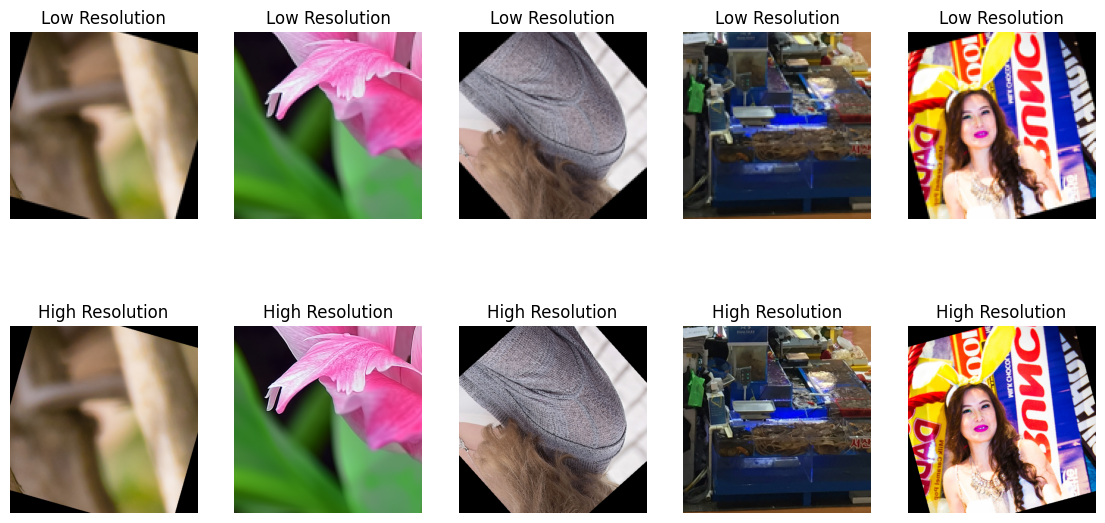

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 173MB/s] 
/usr/local/lib/python3.11/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly.

Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 182MB/s] 


Downloading: "https://huggingface.co/chaofengc/IQA-PyTorch-Weights/resolve/main/LPIPS_v0.1_alex-df73285e.pth" to /root/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth



100%|██████████| 5.87k/5.87k [00:00<00:00, 9.30MB/s]
2025-04-29 09:05:01,025 INFO: Network [LPIPS] is created.
2025-04-29 09:05:01,030 INFO: Metric [LPIPS] is created.


Loading pretrained model LPIPS from /root/.cache/torch/hub/pyiqa/LPIPS_v0.1_alex-df73285e.pth
Downloading: "https://huggingface.co/chaofengc/IQA-PyTorch-Weights/resolve/main/niqe_modelparameters.mat" to /root/.cache/torch/hub/pyiqa/niqe_modelparameters.mat



100%|██████████| 8.15k/8.15k [00:00<00:00, 10.1MB/s]
2025-04-29 09:05:01,214 INFO: Network [NIQE] is created.
2025-04-29 09:05:01,216 INFO: Metric [NIQE] is created.


Model's Total Num Model Parameters: 3839873
The model size is 14.65 MB
Resuming from step runnings/checkpoint_global.pt with : (epoch 0)


Epoch 1/3:  32%|███▏      | 137/432 [15:04<32:12,  6.55s/it, psnr=21.76, ssim=0.5860, lpips=0.4409, loss=5.8903]

In [ ]:
set_seed(42)
# Hyperparameters
config = TrainingConfig()
checkpoint_dir = '/kaggle/working/runnings'
results_dir    = '/kaggle/working/results'
samples_dir    = '/kaggle/working/samples'
generated_dir  = '/kaggle/working/generated'
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(generated_dir, exist_ok=True)

train_dir = '/kaggle/input/df2kdata/DF2K_train_HR'
val_dir   = '/kaggle/input/df2kdata/DF2K_valid_HR'

train_loader, val_loader = create_dataloaders(train_dir, val_dir, batch_size=8, patch_size=512, num_workers=4)

plot_dataset(train_loader)

# Create model and diffusion
model         = CoCAG()
discriminator = Discriminator()

# Initialize trainer
trainer = Trainer(
    model=model,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    config=config
)
trainer.train()
generator = trainer.model

# Inference

In [ ]:
def load_image(image_path):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # Load the image
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)
    return image


def infer(image_path, sharp_file, file_name, trainer, out_name = '/kaggle/working/gen_results', device='cpu', timesteps=1000):

    trainer.device = device
    trainer.model = trainer.model.to(device)
    trainer.model.eval()

    # Load the image
    image = load_image(image_path).to(device)
    print("Processing image: ", image_path)
    print(image.shape)
    sr_imgs = trainer.model(image)
    print(sr_imgs.shape)
    # Save the image
    save_image_tensor(image, out_name+f'normal_{file_name}')
    save_image_tensor(sr_imgs, out_name+f'upsample_16_{file_name}')
    hr_image = load_image(sharp_file).to(device)
    print(hr_image.shape)
    #sr_imgs = F.interpolate(sr_imgs, size=hr_image.shape[2:], mode='bicubic')
    psnr, ssim = calculate_metrics(hr_image, sr_imgs)
    print(f"PSNR: {psnr}, SSIM: {ssim}")
    # Display the original, compressed, and decompressed images
    plt.subplot(1, 3, 1)
    plt.imshow(get_pil_image(image.detach().cpu().squeeze(0)))
    plt.title('Low Resolution Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(get_pil_image(hr_image.detach().cpu().squeeze(0)))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(get_pil_image(sr_imgs.detach().cpu().squeeze(0)))
    plt.title('UpScale Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()
    del hr_image, image, sr_imgs
    torch.cuda.empty_cache()

def extract_file_number(file_name):
    # Extract the numerical part of the file name
    # Example: '0001x4.png' -> 1
    return int(file_name.split('/')[-1].split('x')[0])

def sort_file_names(file_paths):
    # Convert file paths to a PyTorch tensor for sorting
    file_numbers = torch.tensor([extract_file_number(fp) for fp in file_paths])
    
    # Get the sorted indices
    sorted_indices = torch.argsort(file_numbers)
    
    # Sort the file paths based on the sorted indices
    sorted_file_paths = [file_paths[i] for i in sorted_indices]
    return sorted_file_paths

In [ ]:
with torch.no_grad():
    data_path = '/kaggle/input/urban100/Urban 100/X4 Urban100/X4/LOW x4 URban100'
    '/kaggle/input/flickr2k/Flickr2K/Flickr2K_LR_bicubic/X4'
    '/kaggle/input/div2k-dataset-for-super-resolution/Dataset/DIV2K_train_LR_bicubic_X4/X4'
    sharp_dir = '/kaggle/input/urban100/Urban 100/X4 Urban100/X4/HIGH x4 URban100'
    '/kaggle/input/flickr2k/Flickr2K/Flickr2K_HR'
    '/kaggle/input/div2k-dataset-for-super-resolution/Dataset/DIV2K_train_HR'
    #results_dir = 'samples/'
    os.makedirs(results_dir, exist_ok=True)
    list_of_files      = sorted(os.listdir(os.path.join(data_path)))
    list_of_shap_files = sorted(os.listdir(os.path.join(sharp_dir)))
    i = 0
    for j, file in enumerate(list_of_files):
        if file == '.ipynb_checkpoints':
            continue
        file_path  = data_path + '/' + file
        sharp_path = sharp_dir + '/' + list_of_shap_files[i]
        infer(file_path, sharp_path, file, trainer, out_name=results_dir, device='cpu')
        i = i+1
        if i==10:
            break